In [3]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [89]:
from insolver.frame import InsolverDataFrame
from insolver.transforms import InsolverTransform
from insolver.transforms import (
    AutoFillNATransforms,
    OneHotEncoderTransforms,
    TransformMapValues
)
from insolver.wrappers import InsolverGLMWrapper, InsolverGBMWrapper
from insolver.model_tools import ModelMetricsCompare

# Rain in Australia
This dataset contains about 10 years of daily weather observations from many locations across Australia. RainTomorrow is the target variable to predict. 

## InsolverDataFrame
InsolverDataFrame is an updated pandas dataframe with additional functionality.

In [21]:
#https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
dataset = InsolverDataFrame(pd.read_csv("data/weatherAUS.csv"))

In [22]:
dataset.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**Getting information about dataset with InsolverDataFrame.**

In [9]:
dataset.info()

<class 'insolver.frame.frame.InsolverDataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       895

In [10]:
dataset.get_meta_info()

{'type': 'InsolverDataFrame',
 'len': 145460,
 'columns': [{'name': 'Date', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'Location', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'MinTemp', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'MaxTemp', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'Rainfall', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'Evaporation', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'Sunshine', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'WindGustDir', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'WindGustSpeed', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'WindDir9am', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'WindDir3pm', 'dtype': dtype('O'), 'use': 'unknown'},
  {'name': 'WindSpeed9am', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'WindSpeed3pm', 'dtype': dtype('float64'), 'use': 'unknown'},
  {'name': 'Humidity9am', 'dtype': dtype('float64'), 'use':

**Dataset shape**

In [11]:
dataset.shape

(145460, 23)

## Explore RainTomorrow target variable 

**Check for null values**

In [23]:
dataset['RainTomorrow'].isnull().sum()

3267

**Let's delete all raws with null values**

In [24]:
dataset_nan = dataset.iloc[dataset[dataset['RainTomorrow'].isnull()].index]
print(len(dataset_nan))
dataset = dataset.drop(dataset[dataset['RainTomorrow'].isnull()].index)

3267


**Unique values count**

In [15]:
dataset['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

**Distribution of values**

In [16]:
dataset['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

## Explore all variables

**Let's delete Date and Location variables**

In [25]:
dataset.pop('Date')
dataset.pop('Location')
dataset.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [26]:
columns = dataset.columns
columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

**Check for null values**

In [27]:
dataset.isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

**Count of categorical variables**

In [28]:
categorical = [var for var in columns if dataset[var].dtype=='object']
print('Датасет содержит', len(categorical), 'качественных переменных:\n', categorical)

Датасет содержит 5 качественных переменных:
 ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


**Frequency count of categorical variables**

In [32]:
for cat in categorical:
    print(dataset[cat].value_counts(), '\n')

W      9780
SE     9309
E      9071
N      9033
SSE    8993
S      8949
WSW    8901
SW     8797
SSW    8610
WNW    8066
NW     8003
ENE    7992
ESE    7305
NE     7060
NNW    6561
NNE    6433
Name: WindGustDir, dtype: int64 

N      11393
SE      9162
E       9024
SSE     8966
NW      8552
S       8493
W       8260
SW      8237
NNE     7948
NNW     7840
ENE     7735
ESE     7558
NE      7527
SSW     7448
WNW     7194
WSW     6843
Name: WindDir9am, dtype: int64 

SE     10663
W       9911
S       9598
WSW     9329
SW      9182
SSE     9142
N       8667
WNW     8656
NW      8468
ESE     8382
E       8342
NE      8164
SSW     8010
NNW     7733
ENE     7724
NNE     6444
Name: WindDir3pm, dtype: int64 

No     109332
Yes     31455
Name: RainToday, dtype: int64 

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64 



**Count of numerical variables**

In [29]:
numerical = [var for var in columns if dataset[var].dtype=='float64']
print('Датасет содержит', len(numerical), 'количественных переменных:\n', numerical)

Датасет содержит 16 количественных переменных:
 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


## InsolverTransform
Transformations allow you to preprocess data using functions from insolver.transforms. There are several different transformations available such as:
- TransformExp,
- InsolverTransform,
- TransformAge,
- TransformMapValues,
- TransformPolynomizer,
- TransformAgeGender.

Also you can use other transformations to preprocess data:
- AutoFillNATransforms allows to fill NA values in dataset,
- OneHotEncoderTransforms based on sklearn’s OneHotEncoder,
- EncoderTransforms based on sklearn’s LabelEncoder.

In [38]:
dataset_transformed = InsolverTransform(dataset, [
    TransformMapValues('RainTomorrow', {'Yes' : 1, 'No' : 0}),
    TransformMapValues('RainToday', {'Yes' : 1, 'No' : 0}),
    OneHotEncoderTransforms(['WindGustDir', 'WindDir9am', 'WindDir3pm']),
    AutoFillNATransforms(), #Автозаполнение нулевых значений
])

In [39]:
dataset_transformed.ins_transform();

In [40]:
dataset_transformed

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan
0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,4.8,8.5,31.0,15.0,13.0,59.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145455,2.8,23.4,0.0,4.8,8.5,31.0,13.0,11.0,51.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145456,3.6,25.3,0.0,4.8,8.5,22.0,13.0,9.0,56.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145457,5.4,26.9,0.0,4.8,8.5,37.0,9.0,9.0,53.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
dataset_transformed.info()

<class 'insolver.transforms.InsolverTransformMain.InsolverTransform'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 69 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   MinTemp          142193 non-null  float64
 1   MaxTemp          142193 non-null  float64
 2   Rainfall         142193 non-null  float64
 3   Evaporation      142193 non-null  float64
 4   Sunshine         142193 non-null  float64
 5   WindGustSpeed    142193 non-null  float64
 6   WindSpeed9am     142193 non-null  float64
 7   WindSpeed3pm     142193 non-null  float64
 8   Humidity9am      142193 non-null  float64
 9   Humidity3pm      142193 non-null  float64
 10  Pressure9am      142193 non-null  float64
 11  Pressure3pm      142193 non-null  float64
 12  Cloud9am         142193 non-null  float64
 13  Cloud3pm         142193 non-null  float64
 14  Temp9am          142193 non-null  float64
 15  Temp3pm          142193 non-null  float64
 16  RainTo

## Model Wrappers
Model wrappers allow you to perform some model fitting routines using a unified interface across different backend packages. Currently model wrappers implement **Generalized Linear Models** (scikit-learn, h2o) and **Gradient Boosting Machines** (xgboost, lightgbm, catboost).

In [48]:
x, y = dataset_transformed.drop('RainTomorrow', axis=1), dataset_transformed['RainTomorrow']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=5)

In [71]:
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

In [70]:
def show_results(model, x, y, categorical_features=False):

    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=5)
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    
    print('\nAccuracy: {:.4f}'.format(acc_score(y_test, model_pred)))
    print('F1: {:.4f}'.format(f1_metric(y_test, model_pred)))
          
    return model

### Generalized Linear Model
InsolverGLMWrapper implements Generalized Linear Models with support of h2o and scikit-learn packages.

GLM using sklearn backend uses the functionality of TweedieRegressor class from scikit-learn. 

GLM using h2o backend uses the functionality of H2OGeneralizedLinearEstimator class from H2O.


In [72]:
iglm = show_results(InsolverGLMWrapper(backend='sklearn', family=0, standardize=True), x, y)


Accuracy: 0.8163
F1: 0.3617


### Gradient Boosting Machines
InsolverGLMWrapper implements Gradient Boosting Machines with support of xgboost, lightgbm and catboost packages.

In [84]:
%%time
igbm = show_results(InsolverGBMWrapper(backend='lightgbm', task='class', n_estimators=100), x, y)


Accuracy: 0.8525
F1: 0.6119
Wall time: 870 ms


In [83]:
%%time

igbm2 = show_results(InsolverGBMWrapper(backend='catboost', task='class', n_estimators=100), x, y)

Learning rate set to 0.5
0:	learn: 0.4573183	total: 19.1ms	remaining: 1.89s
1:	learn: 0.3956301	total: 38.2ms	remaining: 1.87s
2:	learn: 0.3769076	total: 60.7ms	remaining: 1.96s
3:	learn: 0.3687478	total: 84.9ms	remaining: 2.04s
4:	learn: 0.3651504	total: 109ms	remaining: 2.08s
5:	learn: 0.3623612	total: 136ms	remaining: 2.13s
6:	learn: 0.3605683	total: 160ms	remaining: 2.13s
7:	learn: 0.3578497	total: 185ms	remaining: 2.13s
8:	learn: 0.3565878	total: 209ms	remaining: 2.11s
9:	learn: 0.3554087	total: 234ms	remaining: 2.1s
10:	learn: 0.3543774	total: 263ms	remaining: 2.13s
11:	learn: 0.3533168	total: 288ms	remaining: 2.11s
12:	learn: 0.3525711	total: 312ms	remaining: 2.09s
13:	learn: 0.3513443	total: 336ms	remaining: 2.07s
14:	learn: 0.3504766	total: 356ms	remaining: 2.02s
15:	learn: 0.3498145	total: 375ms	remaining: 1.97s
16:	learn: 0.3486915	total: 395ms	remaining: 1.93s
17:	learn: 0.3478749	total: 416ms	remaining: 1.9s
18:	learn: 0.3470966	total: 437ms	remaining: 1.86s
19:	learn: 0.3

In [81]:
%%time
igbm3 = show_results(InsolverGBMWrapper(backend='xgboost', task='class', n_estimators=100), x, y)


Accuracy: 0.8527
F1: 0.6084
Wall time: 6.77 s


## SHAP feature importance
Method for shap values calculation and corresponding plot of feature importances. 

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

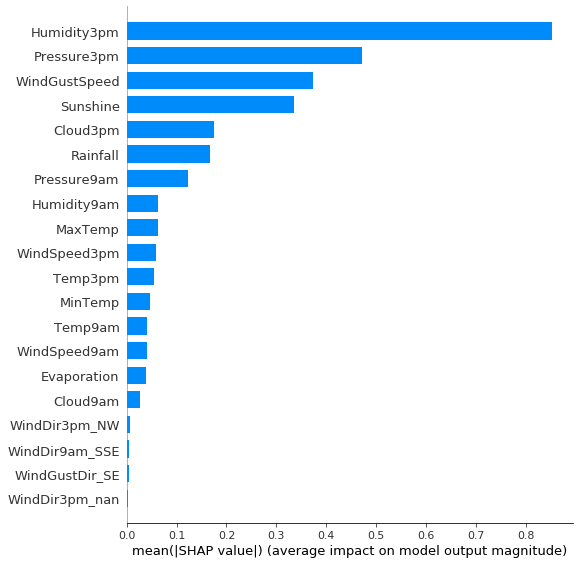

In [87]:
igbm.shap(X_test, show=True);

## Model Comparison
ModelMetricsCompare allows you to compare created models using your metrics.

In [91]:
mc = ModelMetricsCompare(X_test, y_test, source=[igbm, igbm2, igbm3],
                         metrics=[accuracy_score, f1_score])

In [92]:
mc

Model comparison statistics:


,Algo,Backend,Mean,Variance,St. Dev.,Min,Q1,Median,Q3,Max
Actual,-,-,0.224394,0.174042,0.417183,0,0.0,0.0,0.0,1
0,GBM,Lightgbm,0.155616,0.131400,0.362491,0,0.0,0.0,0.0,1
1,GBM,Catboost,0.159273,0.133905,0.365931,0,0.0,0.0,0.0,1
2,GBM,Xgboost,0.151790,0.128750,0.358818,0,0.0,0.0,0.0,1



Models comparison metrics:


,Algo,Backend,accuracy score,f1 score
0,GBM,Lightgbm,0.852513,0.611888
1,GBM,Catboost,0.851951,0.614121
2,GBM,Xgboost,0.852682,0.608390
